[CINTO4003U.LA_F23 (Artificial Intelligence and Machine Learning)](https://cbscanvas.instructure.com/courses/32010) - Copenhagen Business School<br>
***
<br>

# Lab 6: Expert systems

**Expert systems** are computer programs that mimic the decision-making abilities of a human expert in a particular domain or field. They use a set of rules and knowledge-based reasoning to provide specific advice or solutions to problems. On the other hand, machine learning and AI are approaches to creating intelligent systems that can learn inductively from data without being explicitly programmed.

Expert systems are often overlooked due to the current hype surrounding AI. Clients and businesses are eager to implement the latest AI solutions, even when simpler solutions may suffice. Although developing an AI system may be more complex and time-consuming than developing an expert system, the latter can still provide valuable solutions for specific problems, especially in domains with well-established rules and knowledge. In some cases, an expert system may be a more efficient and accurate solution than an AI system, making it important not to overlook their potential.

* Expert systems can be more suitable when the problem domain is well-understood and there is a body of established rules and knowledge available. In such cases, it can be a simple matter of encoding the rules and knowledge into the expert system. Often, this approach can provide more accurate and consistent results than machine learning.

* Likewise, when explanability is essential, expert systems can be a better choice than machine learning and AI systems. They make their decisions based on explicit rules and knowledge, and the reasoning behind their decisions can be explained to the end-users. This transparency can be crucial in some domains, such as medicine and law, where decisions need to be justified and explained.

### Using expert systems with AI
It is often a good idea to start off with an expert system based on rules made by subject-matter experts because it allows for a more controlled approach to problem-solving. Subject-matter experts understand the nuances and intricacies of the domain, and they can provide the necessary rules and knowledge to make the expert system more effective. Additionally, an expert system can serve as a baseline for comparison when transitioning to a machine learning or AI system. The rules and knowledge that form the basis of an expert system can be used to train a machine learning model, allowing for a more accurate and robust system. In this way, expert systems can serve as a stepping stone towards more advanced AI solutions.

---

<br>

In this lab we will introduce [`human-learn`](https://koaning.github.io/human-learn/index.html), a brilliant library for creating expert systems that works in scikit-learn pipelines. Specifically, we will make use of the `FunctionClassifier` class, which works the same way as the scikit-learn classifiers that you are used to. The difference is that you have to pass expert system functions to it.

In [ ]:
!python -m pip install human-learn

In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer, f1_score
from sklearn.metrics import classification_report

from hulearn.datasets import load_titanic
from hulearn.classification import FunctionClassifier
from hulearn.experimental.interactive import parallel_coordinates

### Load and preprocess data
Here we make a few tweaks, so we can jump straight to modelling.

In [3]:
titanic_df = load_titanic(as_frame=True)

titanic_df['sex'] = titanic_df['sex'].map({'female': 0, 'male': 1})
titanic_df['family_size'] = titanic_df['sibsp'] + titanic_df['parch'] + 1
titanic_df['alone'] = np.where(titanic_df['family_size'] == 1, 1, 0)

X, y = titanic_df.drop(columns=['survived', 'name']), titanic_df['survived']

In [9]:
# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build a dummy classifier to compare against

In [10]:
y_pred = DummyClassifier(strategy='most_frequent').fit(X_train, y_train).predict(X_train)
print(f"Our baseline accuracy is: {accuracy_score(y_train, y_pred)}")

Our baseline accuracy is: 0.5901926444833625


### Build our first FunctionClassifier
Let's introduce the FunctionClassifier. As mentioned above, it works in the same way as a regular scikit-learn classifier, except for two big differences
- The `fit` method does nothing, because the is no learning algorithm to fit. The rules are static.  (It still needs to be called though)
- A function containing one or more rules must be passed to the classifier 

let's see it in action

In [11]:
def fare_based(dataf, threshold=15):

    """ 
    This expert system function returns 1 ('survived') 
    if the fare price is greater than the threshold 
    or 0 ('didn't survive') otherwise.
    """
    
    return (dataf['fare'] > threshold).astype(int)

xp_clf = FunctionClassifier(fare_based, threshold=15)

In [12]:
y_pred = (
    xp_clf
    .fit(X_train, y_train) # this step does nothing but is required
    .predict(X_train) # predict using our expert system
)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.61      0.66       337
           1       0.55      0.68      0.61       234

    accuracy                           0.64       571
   macro avg       0.64      0.64      0.64       571
weighted avg       0.66      0.64      0.64       571



As we can see above, this simple rule does quite a bit better than our baseline! <br>
**But** how do we know which threshold to pass to the function? We can gridsearch it!

### Gridsearch expert rules

In [15]:
mod = FunctionClassifier(fare_based, threshold=10)
grid = GridSearchCV(
    mod, 
    cv=2, 
    param_grid={'threshold': np.linspace(0, 100, 30)},
    scoring={'accuracy': make_scorer(accuracy_score), 
              'precision': make_scorer(precision_score),
              'recall': make_scorer(recall_score),
              },
    refit='accuracy'
)
grid.fit(X, y)

GridSearchCV(cv=2,
             estimator=FunctionClassifier(func=<function fare_based at 0x15a8b1760>,
                                          threshold=10),
             param_grid={'threshold': array([  0.        ,   3.44827586,   6.89655172,  10.34482759,
        13.79310345,  17.24137931,  20.68965517,  24.13793103,
        27.5862069 ,  31.03448276,  34.48275862,  37.93103448,
        41.37931034,  44.82758621,  48.27586207,  51.72413793,
        55.17241379,  58.62068966,  62.06896552,  65.51724138,
        68.96551724,  72.4137931 ,  75.86206897,  79.31034483,
        82.75862069,  86.20689655,  89.65517241,  93.10344828,
        96.55172414, 100.        ])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

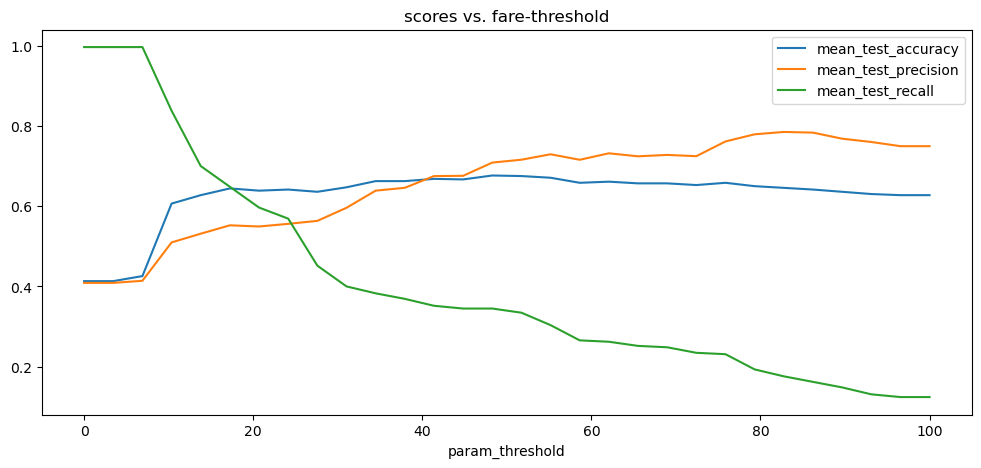

In [16]:

score_df = (
    pd.DataFrame(grid.cv_results_)
    .set_index('param_threshold')
    [['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]
)

score_df.plot(
    figsize=(12, 5), 
    title="scores vs. fare-threshold"
);

### Adding rules

We can add as many rules as we want to, to our neat little expert system. 
Maybe we could say
- IF 'fare' > t
- OR 'sex' == s

THEN predict 1 else 0

We might make the second rule because we heuristically assume that women have a higher chance of surviving shipwrecks.<br>

In [17]:
def rule_factory(
        dataf,
        r1_fare_threshold = 15, 
        r2_gender_category = 0,
    ):

    # rule 1: if the fare is greater than the threshold, then survived
    rule1 = (dataf['fare'] > r1_fare_threshold)

    # rule 2: if the gender is equal to the gender category, then survived
    rule2 = (dataf['sex'] == r2_gender_category)
    
    return (rule1 | rule2).astype(int) # 1 if either rule is true, 0 otherwise

In [18]:
xp_clf = FunctionClassifier(
    rule_factory,
    r1_fare_threshold=15,
    r2_gender_category=0,

)

y_pred = (
    xp_clf
    .fit(X_train, y_train) # this step does nothing but is required
    .predict(X_train) # predict using our expert system
)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.54      0.67       337
           1       0.57      0.88      0.69       234

    accuracy                           0.68       571
   macro avg       0.72      0.71      0.68       571
weighted avg       0.75      0.68      0.68       571



### Gridsearch with more rules

In [19]:
mod = FunctionClassifier(rule_factory, r1_fare_threshold=10, r2_gender_category=0)
grid = GridSearchCV(
    mod, 
    cv=2, 
    param_grid={
        'r1_fare_threshold': np.linspace(0, 100, 30),
        'r2_gender_category': [0, 1],
    },
    scoring={
        'accuracy': make_scorer(accuracy_score), 
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
    },
    refit='accuracy',
    verbose=1
)
grid.fit(X, y)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


GridSearchCV(cv=2,
             estimator=FunctionClassifier(func=<function rule_factory at 0x15bb5f560>,
                                          r1_fare_threshold=10,
                                          r2_gender_category=0),
             param_grid={'r1_fare_threshold': array([  0.        ,   3.44827586,   6.89655172,  10.34482759,
        13.79310345,  17.24137931,  20.68965517,  24.13793103,
        27.5862069 ,  31.03448276,  34.48275862,  37.93103448,
        41.37931034,  44.82758621,  48.27586207,  51.72413793,
        55.17241379,  58.62068966,  62.06896552,  65.51724138,
        68.96551724,  72.4137931 ,  75.86206897,  79.31034483,
        82.75862069,  86.20689655,  89.65517241,  93.10344828,
        96.55172414, 100.        ]),
                         'r2_gender_category': [0, 1]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=1)

In [21]:
score_df = (
    pd.DataFrame(grid.cv_results_)
    [[
        'param_r1_fare_threshold', 
        'param_r2_gender_category', 
        
        'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]
    .sort_values('mean_test_accuracy', ascending=False)
    .head(5)   
)
score_df

,param_r1_fare_threshold,param_r2_gender_category,mean_test_accuracy,mean_test_precision,mean_test_recall
50,86.206897,0,0.778711,0.734316,0.713793
52,89.655172,0,0.777311,0.733349,0.710345
48,82.758621,0,0.777311,0.731857,0.713793
46,79.310345,0,0.775910,0.727986,0.717241
58,100.0,0,0.775910,0.733938,0.703448


### Find rules using hi plot
The `parallel_coordinates` from the `hulearn` library gives us HTML rendering of a *hi plot*. Each column is a feature in our dataset. Each line is a row in our dataset (a training example). The color indicates which class (survived or not) that the given example belongs to.
By clicking and dragging on the columns, we can filter the examples. This can be used as inspiration to decide on new expert system rules to come up with.

In [22]:
train = X_train.merge(y_train, left_index=True, right_index=True)

parallel_coordinates(train, label="survived", height=400)

---------
--------

# Question 1

- Come up with **at least** 1 new rule (Mabe something with age? Perhaps using the hi plot above?)
- Add the new rule to the `rule_factory` function and use it to create a new `FunctionClassifier`. 
- Evaluate the results on (X_train, y_train) using a classification report

# Question 2

- Gridsearch your new FunctionClassifier (as above)
- Report on the results

# Question 3

* Evaluate the best gridsearch model on (X_test, y_test) (using `grid.predict()`)
* Report on the results, and consider the precision and recall. 

# Question 4

* Build a logistic regression classifier
* Train it on (X_train, y_train)
* Evaluate it on (X_test, y_test)
* Compare with the gridsearched FunctionClassifier